In [1]:
# from the team_hit virtualenv in Python

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import contractions
import collections
import shap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import timeit
import shap
import eli5


In [3]:
# load the nltk specific parameters
stop_words = nltk.corpus.stopwords.words('english')

# set the seaborn pallet
sns.color_palette('dark')

# define the confusion matrix
cm_ = metrics.confusion_matrix

## 1. Configure the YES/NO hurricane data 
From the training data for hurricanes Mathew, Irma, Maria, and Harvey

In [4]:
# training data of tweets knowns to relate to hurricanes Mathew, Maria, Irma and Harvey

df_yes = pd.read_csv('./DATA/all_hurricanes_tweets_train.csv')
df_yes['is_hurricane'] = 1
df_yes.shape

(13209, 19)

In [5]:
# tweets selected from the same time periods based on terms not related to hurricanes 

df_no = pd.read_csv('./DATA/mix_2016_2017_not_hurricane.csv')
df_no = df_no.rename({'id': 'tweet_id'}, axis=1)
df_no['is_hurricane'] = 0
df_no.shape

(20610, 17)

In [6]:
# ensure the same number of hurrican tweets and not hurricane tweets
df_no = df_no.sample(n = 13209)
df_no.shape

(13209, 17)

In [7]:
# features from the hurricane dataset

yes_features = set(list(df_yes.columns))
yes_features

{'Unnamed: 0',
 'attachments',
 'author_id',
 'class_label',
 'context_annotations',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'entities',
 'in_reply_to_user_id',
 'is_hurricane',
 'lang',
 'possibly_sensitive',
 'public_metrics',
 'referenced_tweets',
 'reply_settings',
 'source',
 'text',
 'tweet_id'}

In [8]:
# features from the not hurricane dataset

no_features = set(list(df_no.columns))
no_features

{'attachments',
 'author_id',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'entities',
 'in_reply_to_user_id',
 'is_hurricane',
 'lang',
 'possibly_sensitive',
 'public_metrics',
 'referenced_tweets',
 'reply_settings',
 'source',
 'text',
 'tweet_id',
 'withheld'}

In [9]:
# features unique to either of the two datasets -- retain class_label for category within hurricanes 
# ***** But withhold from training the YES/NO classifier ***** 
print(list(yes_features.union(no_features)))
yes_features.symmetric_difference(no_features)

['conversation_id', 'source', 'tweet_id', 'entities', 'public_metrics', 'text', 'possibly_sensitive', 'withheld', 'in_reply_to_user_id', 'Unnamed: 0', 'edit_history_tweet_ids', 'author_id', 'attachments', 'reply_settings', 'context_annotations', 'class_label', 'referenced_tweets', 'is_hurricane', 'lang', 'created_at']


{'Unnamed: 0', 'class_label', 'context_annotations', 'withheld'}

In [10]:
df = pd.concat([df_yes, df_no])
df.shape

(26418, 20)

In [11]:
retain_features = ['created_at', 'edit_history_tweet_ids', 'author_id', 'source', 'in_reply_to_user_id', 'text', 'conversation_id', 'class_label', 'reply_settings', 'tweet_id', 'entities', 'attachments', 'lang', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'is_hurricane']
len(retain_features)

17

In [12]:
df = df[retain_features]
df.shape

(26418, 17)

In [13]:
# X features: remove class_label and is_hurricane from df
X_features = ['created_at', 'edit_history_tweet_ids', 'author_id', 'source', 'in_reply_to_user_id', 'text', 'conversation_id', 'reply_settings', 'tweet_id', 'entities', 'attachments', 'lang', 'public_metrics', 'referenced_tweets', 'possibly_sensitive']
X_ = df[X_features]
X_.shape

(26418, 15)

In [14]:
# y is the label of YES/NO is_hurricane
y = df['is_hurricane']
y.shape

(26418,)

## 2. Preprocess the text

In [15]:
# select or combine lemmatization, stemming, stopword removal to compare performance

def preprocess_text(text, flg_stemm = True, flg_lemm = True, lst_stopwords=None):
    text_clean = re.sub(r'[^\w\s.,]', '', str(text).strip())
    lst_text = text_clean.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if flg_stemm == True:
        stemm = nltk.stem.porter.PorterStemmer()
        lst_text = [stemm.stem(word) for word in lst_text]
    if flg_lemm == True:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    text_clean = ' '.join(filter(None, lst_text))
    text_clean = text_clean.replace(" ,",",").replace(' .', '.')
    text_clean = contractions.fix(text_clean)
    return text_clean

In [16]:
X = X_['text'].apply(lambda x: preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))
X.shape

(26418,)

## 3. Train-Test split the data

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42, test_size=0.20, shuffle=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df = 3)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

## 4. Initial performance on default parameters 

accuracy precision    recall  f1-score
Logistic Regression  0.978993   0.97913  0.979053  0.978993
MultinomialNB         0.96707  0.967066  0.967074  0.967069
RandomForest         0.978425  0.978423  0.978441  0.978425
SVM                  0.983346  0.983423  0.983393  0.983346
MLP                  0.975019  0.975104  0.975068  0.975019

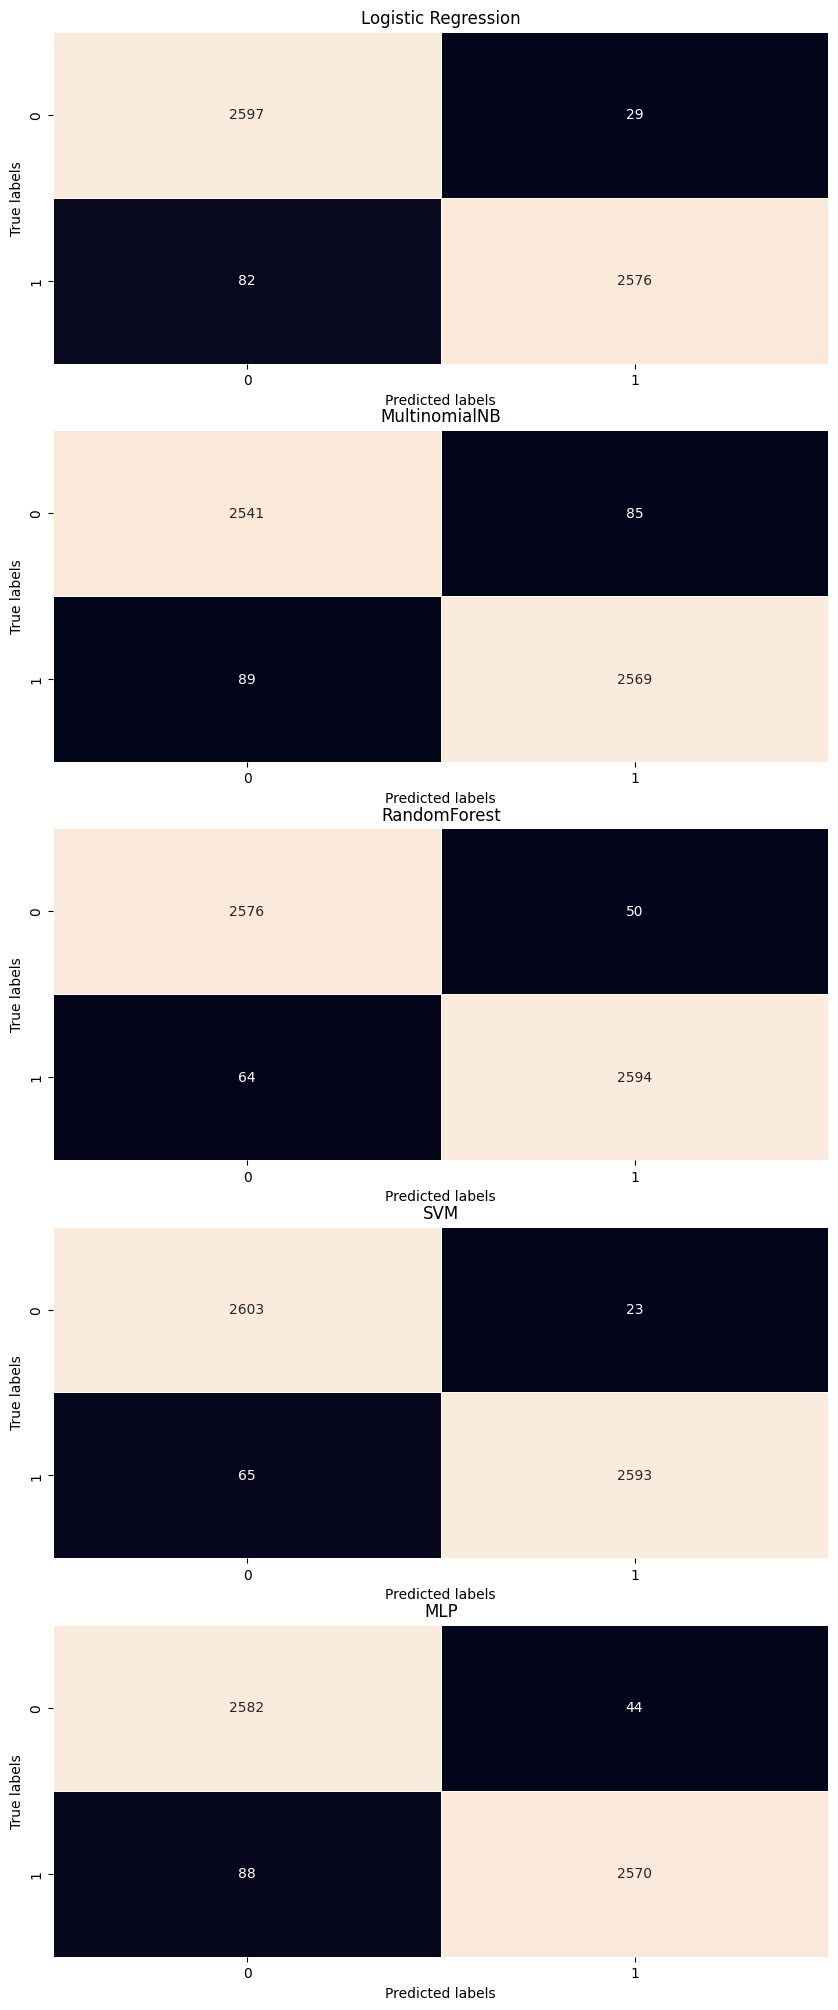

In [18]:
seed = 42

models = {"Logistic Regression": LogisticRegression(),
          "MultinomialNB": MultinomialNB(),
          "RandomForest": RandomForestClassifier(),
          "SVM": SVC(), #boxed out due to computational cost
          "MLP": MLPClassifier()
          }

results_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

target_names = ['Not Hurricane Tweet', 'Hurricane Tweet']

fig, ax = plt.subplots(5,1, figsize=(10, 25))
ax_idx = 0

for name, model in models.items():
    
    fit = model.fit(train_vc, y_train)
    pred = model.predict(test_vc)

    report_dict = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
        
    results_df.loc[name, 'accuracy'] = report_dict['accuracy']
    results_df.loc[name, 'precision'] = report_dict['macro avg']['precision']
    results_df.loc[name, 'recall'] = report_dict['macro avg']['recall']
    results_df.loc[name, 'f1-score'] = report_dict['macro avg']['f1-score']

    cm = cm_(y_test, pred)
    ax_ = ax[ax_idx]
    sns.heatmap(cm, annot=True,ax=ax_, fmt='g', linewidth=0.5, cbar=False)
    ax_.set_title(name)
    ax_.set_xlabel("Predicted labels")
    ax_.set_ylabel("True labels")
    ax_idx += 1

results_df

In [19]:
# try seaborn https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

# https://seaborn.pydata.org/tutorial/color_palettes.html

## 5. Grid Search to optimize paramters 

### a. Logistic Regression

In [20]:
lr_classifier = LogisticRegression()
lr_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['auto', 'ovr', 'multinomial']}

In [21]:
lr_best = GridSearchCV(lr_classifier, lr_parameters)
lr_best.fit(train_vc, y_train)
lr_best.best_params_
lr_pred = lr_best.predict(test_vc)
metrics.classification_report(y_test, lr_pred, target_names=target_names, output_dict=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'Not Hurricane Tweet': {'precision': 0.974812030075188,
  'recall': 0.9874333587204874,
  'f1-score': 0.981082103670072,
  'support': 2626},
 'Hurricane Tweet': {'precision': 0.9874237804878049,
  'recall': 0.9747930775018812,
  'f1-score': 0.9810677773570616,
  'support': 2658},
 'accuracy': 0.9810749432248297,
 'macro avg': {'precision': 0.9811179052814964,
  'recall': 0.9811132181111843,
  'f1-score': 0.9810749405135668,
  'support': 5284},
 'weighted avg': {'precision': 0.9811560937763114,
  'recall': 0.9810749432248297,
  'f1-score': 0.9810748971333608,
  'support': 5284}}

In [22]:
# best parameters for logistic regression
best_logistic_regression = lr_best.best_params_

lr_best.best_params_

{'C': 10, 'multi_class': 'multinomial', 'penalty': 'l2'}

### 5.b. Naive Bayes

In [23]:
nb_classifier = MultinomialNB()
nb_parameters = {'alpha' : [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], 'fit_prior' : ['True', 'False']}

In [24]:
nb_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
nb_best.fit(train_vc, y_train)
nb_best.best_params_
nb_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, nb_pred, target_names=target_names, output_dict=True)


{'Not Hurricane Tweet': {'precision': 0.9661596958174905,
  'recall': 0.9676313785224676,
  'f1-score': 0.9668949771689499,
  'support': 2626},
 'Hurricane Tweet': {'precision': 0.9679728711379051,
  'recall': 0.9665161775771257,
  'f1-score': 0.9672439759036144,
  'support': 2658},
 'accuracy': 0.9670704012112036,
 'macro avg': {'precision': 0.9670662834776977,
  'recall': 0.9670737780497967,
  'f1-score': 0.9670694765362822,
  'support': 5284},
 'weighted avg': {'precision': 0.967071773789039,
  'recall': 0.9670704012112036,
  'f1-score': 0.967070533307621,
  'support': 5284}}

In [25]:
# best parameters for naive bayes
nb_best.best_params_

{'alpha': 1, 'fit_prior': 'True'}

### 5.c. Random Forest

In [26]:
rf_classifier = RandomForestClassifier()
rf_parameters = {'n_estimators' : [100, 200, 300], 'max_depth': [3, 5, 10]}

In [27]:
rf_best = GridSearchCV(rf_classifier, rf_parameters, cv=5)
rf_best.fit(train_vc, y_train)
rf_best.best_params_
rf_pred = rf_best.predict(test_vc)
metrics.classification_report(y_test, rf_pred, target_names=target_names, output_dict=True)

{'Not Hurricane Tweet': {'precision': 0.8923551594103531,
  'recall': 0.9912414318354913,
  'f1-score': 0.939202597871189,
  'support': 2626},
 'Hurricane Tweet': {'precision': 0.9902830587241234,
  'recall': 0.8818660647103085,
  'f1-score': 0.9329353233830846,
  'support': 2658},
 'accuracy': 0.936222558667676,
 'macro avg': {'precision': 0.9413191090672383,
  'recall': 0.9365537482728998,
  'f1-score': 0.9360689606271368,
  'support': 5284},
 'weighted avg': {'precision': 0.9416156356359401,
  'recall': 0.936222558667676,
  'f1-score': 0.9360499832630548,
  'support': 5284}}

In [28]:
# best parameters for random forest
rf_best.best_params_

{'max_depth': 10, 'n_estimators': 200}

### 5.d. Support Vector Machine

In [29]:
svm_classifier = SVC()

In [30]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']} 

In [31]:
# svm_best = GridSearchCV(svm_classifier, param_grid, cv=5)

In [32]:
# svm_best.fit(train_vc, y_train)
# svm_best.best_params_
# svm_pred = svm_best.predict(test_vc)
# metrics.classification_report(y_test, svm_pred, target_names=target_names, output_dict=True)

In [33]:
# svm_best.best_params_

In [34]:
# 2 hours 30 min to derive this... 
best_svc = {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

## 5.e Multi-layer Perceptron

In [35]:
MLPClassifier = MLPClassifier()
mlp_parameters = {'hidden_layer_sizes' : [10, 50, 100, 200], 
                  'activation' : ['identity', 'logistic', 'tanh', 'relu'], 
                  'alpha' : ['0.0001', '0.001', '0.01', '0.1'],
                 'learning_rate_init': np.arange(0.01,1.01,0.01),}

In [36]:
mlp_best = GridSearchCV(MLPClassifier, mlp_parameters, cv=5, error_score='raise')

In [37]:
mlp_best

GridSearchCV(cv=5, error_score='raise', estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': ['0.0001', '0.001', '0.01', '0.1'],
                         'hidden_layer_sizes': [10, 50, 100, 200],
                         'learning_rate_init': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24,..., 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])})

In [38]:
#tr = train_vc.toarray(order='C')

In [39]:
#type(tr), type(train_vc)

In [40]:
# tr

In [41]:
# mlp_best.fit(train_vc, y_train)
# mlp_best.fit(tr, y_train)

In [42]:
# mlp_best.best_params_

In [43]:
# mlp_pred = mlp_best.predict(test_vc)

In [44]:
# metrics.classification_report(y_test, mlp_pred, target_names=target_names, output_dict=True)

In [45]:
# mlp_best.best_params_

In [46]:
# MLP Error:
# TypeError: '<' not supported between instances of 'str' and 'float'

## 6. Performance of Optimized Models

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


accuracy precision    recall  f1-score
Logistic Regression  0.981075  0.981118  0.981113  0.981075
MultinomialNB         0.96707  0.967066  0.967074  0.967069
RandomForest         0.943225  0.946693  0.943498  0.943137
SVC                  0.983157  0.983203  0.983196  0.983157

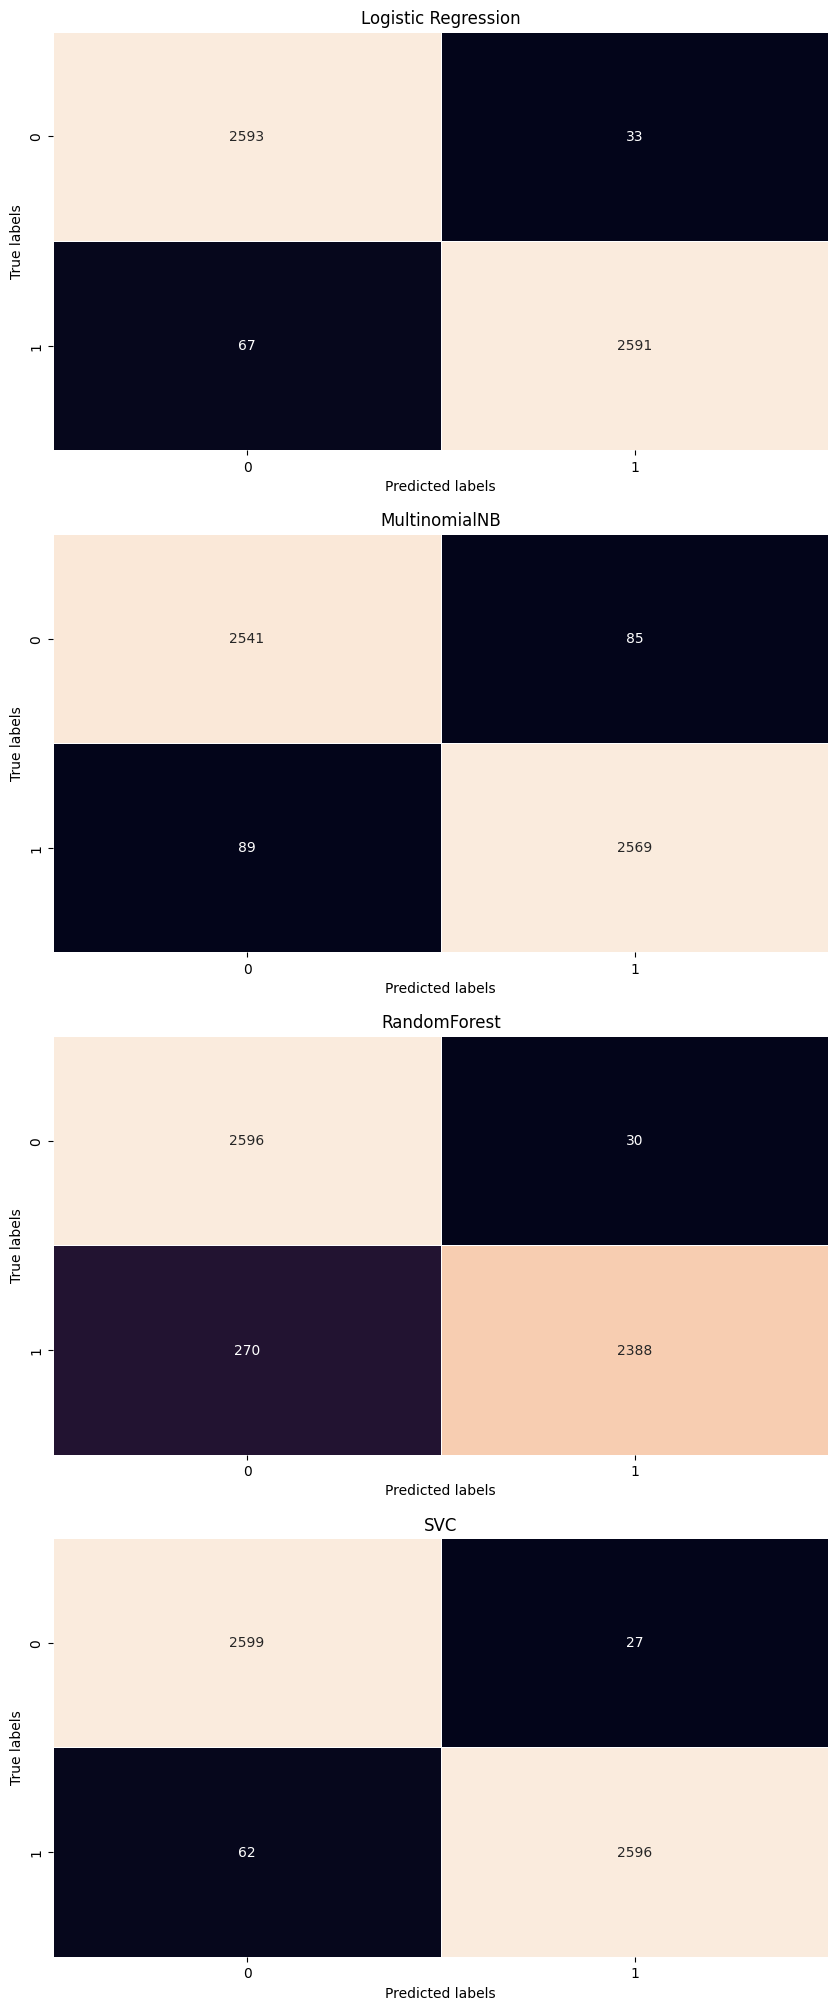

In [47]:
# # test optimized classifiers

models = {"Logistic Regression": LogisticRegression(C=10, multi_class='multinomial', penalty='l2'),
          "MultinomialNB": MultinomialNB(fit_prior=True, alpha=1),
          "RandomForest": RandomForestClassifier(n_estimators=300, max_depth = 10),
          "SVC": SVC(kernel='rbf', gamma=1, C=10),
#          "MLP": MLPClassifier(hidden_layer_sizes=200, activation='tanh', solver='adam', alpha=0.001)
          }

#fit classifiers and make predictions

results_df2 = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

target_names = ['Not Hurricane Tweet', 'Hurricane Tweet']

fig, ax = plt.subplots(4,1, figsize=(10, 25))
ax_idx = 0

for name, model in models.items():
    
    fit = model.fit(train_vc, y_train)
    pred = model.predict(test_vc)

    report_dict = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
        
    results_df2.loc[name, 'accuracy'] = report_dict['accuracy']
    results_df2.loc[name, 'precision'] = report_dict['macro avg']['precision']
    results_df2.loc[name, 'recall'] = report_dict['macro avg']['recall']
    results_df2.loc[name, 'f1-score'] = report_dict['macro avg']['f1-score']

    cm = cm_(y_test, pred)
    ax_ = ax[ax_idx]
    sns.heatmap(cm, annot=True,ax=ax_, fmt='g', linewidth=0.5, cbar=False)
    ax_.set_title(name)
    ax_.set_xlabel("Predicted labels")
    ax_.set_ylabel("True labels")
    ax_idx += 1

results_df2

### 6.a. Comparison of performance between Default and Optimized

In [53]:
# default values 
results_df

accuracy precision    recall  f1-score
Logistic Regression  0.978993   0.97913  0.979053  0.978993
MultinomialNB         0.96707  0.967066  0.967074  0.967069
RandomForest         0.978425  0.978423  0.978441  0.978425
SVM                  0.983346  0.983423  0.983393  0.983346
MLP                  0.975019  0.975104  0.975068  0.975019

In [54]:
# optimized values based on Grid Search
results_df2

accuracy precision    recall  f1-score
Logistic Regression  0.981075  0.981118  0.981113  0.981075
MultinomialNB         0.96707  0.967066  0.967074  0.967069
RandomForest         0.943225  0.946693  0.943498  0.943137
SVC                  0.983157  0.983203  0.983196  0.983157

## 7. LIME, SHAP and eli5 text-explainer analysis

In [58]:
type(X_train.index[100])

numpy.int64

For some reason this time through index 100 has an integer; index values were changed to 101

In [59]:
#LIME-LR
lr_classifier = LogisticRegression(C=10, multi_class='multinomial', penalty='l2')
lr_classifier.fit(train_vc, y_train)

idx = X_train.index[101]
c = make_pipeline(tfidf_vec, lr_classifier)
explainer = LimeTextExplainer(class_names=target_names)
exp = explainer.explain_instance(X_train[idx], c.predict_proba, num_features = 10, top_labels=9)
exp.show_in_notebook(text=False)
exp.as_list()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[('hurrican', 0.08264419790527795),
 ('maria', 0.07442364634505039),
 ('destruct', 0.0697038270290533),
 ('puerto', 0.0576430218604451),
 ('rico', 0.05395657141807841),
 ('one', -0.020180325435957054),
 ('http', -0.019064338789232853),
 ('united', -0.015219205195896432),
 ('event', 0.013273919521573209),
 ('mass', -0.009626639184329835)]

In [61]:
#LIME-MultinomialNB
nb_classifier = MultinomialNB(fit_prior=True, alpha=100)
nb_classifier.fit(train_vc, y_train)

idx = X_train.index[101]
c = make_pipeline(tfidf_vec, nb_classifier)
explainer = LimeTextExplainer(class_names=target_names)
exp = explainer.explain_instance(X_train[idx], c.predict_proba, num_features = 10, top_labels=9)
exp.show_in_notebook(text=False)
exp.as_list()

[('hurrican', 0.0696081683650783),
 ('maria', 0.059727304821462414),
 ('rico', 0.05877467895990537),
 ('puerto', 0.05248484378794096),
 ('united', -0.017785839450888626),
 ('one', -0.017100919317148636),
 ('spawn', -0.014920173578368877),
 ('mass', -0.012806032623321573),
 ('event', -0.009867126933534587),
 ('rt', -0.009071569430524323)]

In [62]:
#LIME-RandomForest
rf_classifier = RandomForestClassifier(max_depth=10)
rf_classifier.fit(train_vc, y_train)

idx = X_train.index[101]
c = make_pipeline(tfidf_vec, rf_classifier)
explainer = LimeTextExplainer(class_names=target_names)
exp = explainer.explain_instance(X_train[idx], c.predict_proba, num_features = 10, top_labels=9)
exp.show_in_notebook(text=False)
exp.as_list()

[('maria', 0.071133392478274),
 ('hurrican', 0.04249393510451377),
 ('puerto', 0.04169600366120164),
 ('rico', 0.03564778172702242),
 ('destruct', 0.023081082514170313),
 ('rt', -0.005934702256018455),
 ('spawn', 0.003295276029659135),
 ('united', 0.00310477010590583),
 ('http', 0.0030584761335661075),
 ('largest', 0.002333369802340434)]

### 7.b. SHAP

In [63]:
#SHAP analysis
#convert class_label to numeric to fit for SHAP

le = preprocessing.LabelEncoder()
le.fit(df.class_label)
df['class_label_num'] = le.transform(df.class_label)
df.shape

(26418, 18)

  0%|          | 0/5 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

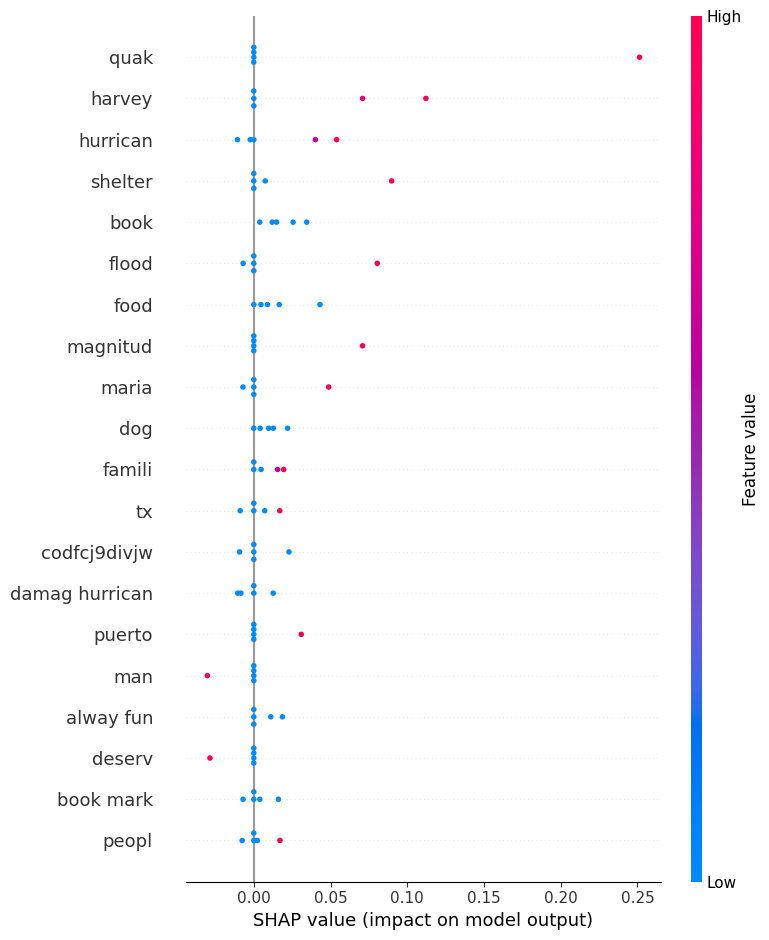

In [64]:
# SVM example

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, shuffle=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

svm_classifier = SVC(kernel='rbf', gamma=1, C=10)
svm_classifier.fit(train_vc, y_train)

X_train_sample = shap.sample(train_vc, 100)
X_test_sample = shap.sample(test_vc, 5)
explainer = shap.KernelExplainer(svm_classifier.predict, X_train_sample, l1_reg="rank(3)")
shap_vals = explainer.shap_values(X_test_sample)
colour_df = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_df, feature_names=tfidf_vec.get_feature_names())